In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from string import digits
import re
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Input, Dense,Embedding, Concatenate, TimeDistributed
from tensorflow.keras.models import Model,load_model, model_from_json
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Read the Data and Create DF

In [2]:
text = open('data/pol.txt').read().split('\n')
print(len(text))

41179


In [3]:
language_df = pd.DataFrame(columns=['en', 'pl'])
en_list = []
pl_list = []
for sentences in text:
  try:
    sentence = sentences.split('\t')
    pl_list.append(sentence[1])
    en_list.append(sentence[0])
  except: 
    continue

language_df['en'] = en_list
language_df['pl'] = pl_list
language_df.head()

,en,pl
0,Go.,Idź.
1,Hi.,Cześć.
2,Run!,Uciekaj!
3,Run.,Biegnij.
4,Run.,Uciekaj.


# Data Cleaning

In [4]:
def clean_text(text):
    # to lower case and remove spaces and end and start
    text = text.lower().strip()
    # remove digits
    text = re.sub('\d', '', text)
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

language_df['en'] = language_df['en'].apply(clean_text)
language_df['pl'] = language_df['pl'].apply(clean_text)
language_df.head()

,en,pl
0,go,idź
1,hi,cześć
2,run,uciekaj
3,run,biegnij
4,run,uciekaj


In [5]:
# putting START and END in polish sentences
language_df['pl'] = language_df['pl'].apply(lambda text: "START "+text+" END")
print("English Sentence: " + language_df['en'].iloc[0])
print("Polish Sentence: " + language_df['pl'].iloc[0])

English Sentence: go
Polish Sentence: START idź END


# Data Preparation for Model Building

In [6]:
import numpy as np

# train test split
x = language_df['en']
y = language_df['pl']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

# determine the maximum length of sentence
def determine_sentence_len(data):
    lenghts = [len(x.split(' ')) for x in data]
    return round(np.mean(lenghts) + 2 * np.std(lenghts))
max_len_en = determine_sentence_len(x_train)
max_len_pl = determine_sentence_len(y_train)
max_len_en, max_len_pl


(11, 12)

In [7]:
# Tokenization
en_tokenizer = Tokenizer()
en_tokenizer.fit_on_texts(x_train)
en_word2index = en_tokenizer.word_index
vocab_size_en = len(en_word2index) + 1

x_train = en_tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(x_train, maxlen=max_len_en, padding='post')
x_test = en_tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(x_test, maxlen = max_len_en, padding='post')

pl_tokenizer = Tokenizer()
pl_tokenizer.fit_on_texts(y_train)
pl_word2index = pl_tokenizer.word_index
vocab_size_pl = len(pl_word2index) + 1

y_train = pl_tokenizer.texts_to_sequences(y_train)
y_train = pad_sequences(y_train, maxlen=max_len_pl, padding='post')
y_test = pl_tokenizer.texts_to_sequences(y_test)
y_test = pad_sequences(y_test, maxlen = max_len_pl, padding='post')

vocab_size_en, vocab_size_pl

(8044, 20242)

In [8]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_train[0], y_train[0]

(array([ 19, 683,   2,  15,   0,   0,   0,   0,   0,   0,   0], dtype=int32),
 array([   1,    3, 3329,   17,    2,    0,    0,    0,    0,    0,    0,
           0], dtype=int32))

# Define Model

## Encoder

In [9]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500
# Encoder 
encoder_inputs = Input(shape=(max_len_en,)) 
enc_emb = Embedding(vocab_size_en, latent_dim,trainable=True)(encoder_inputs)
#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

## Decoder

In [10]:
# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(vocab_size_pl, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs)
#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])
#Dense layer
decoder_dense = Dense(vocab_size_pl, activation='softmax') 
decoder_outputs = decoder_dense(decoder_outputs)

## Define Model

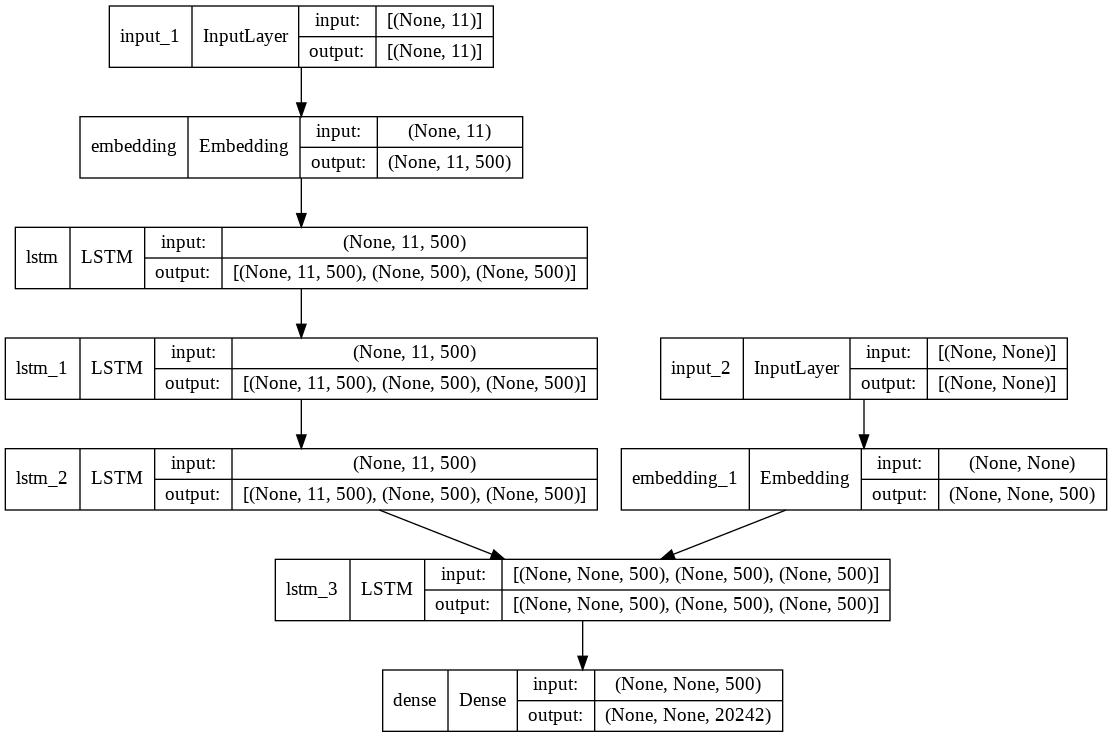

In [11]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
plot_model(model, show_shapes=True)

In [12]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history = model.fit([x_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1],1)[:,1:],
                    epochs=50,
                    batch_size=512,
                    validation_data = ([x_test, y_test[:,:-1]], y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))

Epoch 1/50
73/73 [==============================] - 53s 603ms/step - loss: 3.9719 - accuracy: 0.5097 - val_loss: 3.0879 - val_accuracy: 0.5916
Epoch 2/50
73/73 [==============================] - 42s 576ms/step - loss: 3.2531 - accuracy: 0.5753 - val_loss: 2.8889 - val_accuracy: 0.5999
Epoch 3/50
73/73 [==============================] - 42s 576ms/step - loss: 3.0226 - accuracy: 0.5902 - val_loss: 2.7100 - val_accuracy: 0.6187
Epoch 4/50
73/73 [==============================] - 42s 575ms/step - loss: 2.8174 - accuracy: 0.6072 - val_loss: 2.5833 - val_accuracy: 0.6313
Epoch 5/50
73/73 [==============================] - 42s 577ms/step - loss: 2.6348 - accuracy: 0.6210 - val_loss: 2.4444 - val_accuracy: 0.6451
Epoch 6/50
73/73 [==============================] - 42s 574ms/step - loss: 2.4676 - accuracy: 0.6342 - val_loss: 2.3607 - val_accuracy: 0.6540
Epoch 7/50
73/73 [==============================] - 42s 576ms/step - loss: 2.3145 - accuracy: 0.6470 - val_loss: 2.2757 - val_accuracy: 0.6609

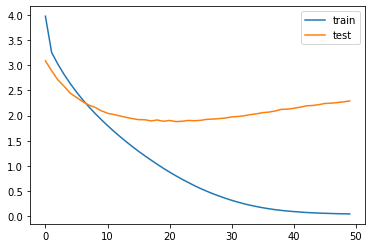

In [13]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Make a Predictions

In [19]:
latent_dim=500
# encoder inference
encoder_inputs = model.input[0]  #loading encoder_inputs
encoder_outputs, state_h, state_c = model.layers[6].output #loading encoder_outputs
#print(encoder_outputs.shape)
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_pl-1,latent_dim))
# Get the embeddings of the decoder sequence
decoder_inputs = model.layers[3].output
#print(decoder_inputs.shape)
dec_emb_layer = model.layers[5]
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_lstm = model.layers[7]
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_dense = model.layers[-1]
decoder_outputs2 = decoder_dense(decoder_outputs2)
# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [20]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = pl_word2index['start']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
      # Sample a token
      sampled_token_index = np.argmax(output_tokens[0, -1, :])
      if sampled_token_index == 0:
        break
      else:
        sampled_token = pl_index2word[sampled_token_index]
        if(sampled_token!='end'):
          decoded_sentence += ' '+sampled_token
          # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_pl-1)):
          stop_condition = True
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # Update internal states
        e_h, e_c = h, c
    return decoded_sentence

In [21]:
en_index2word = en_tokenizer.index_word
pl_index2word = pl_tokenizer.index_word
def seq2summary(input_seq):
    new_string = ''
    for i in input_seq:
      if((i!=0 and i!=pl_word2index['start']) and i!=pl_word2index['end']):
        new_string += pl_index2word[i]+' '
    return new_string

def seq2text(input_seq):
    new_string=''
    for i in input_seq:
      if(i!=0):
        new_string += en_index2word[i]+' '
    return new_string

In [23]:
for i in range(10):  
  print("Review:",seq2text(x_train[i]))
  print("Original summary:",seq2summary(y_train[i]))
  print("Predicted summary:",decode_sequence(x_train[i].reshape(1,max_len_pl-1)))
  print("\n")

Review: dont lie to me 
Original summary: nie kłam mi 
Predicted summary:  nie kłam mi


Review: tom loves gambling 
Original summary: tom uwielbia hazard 
Predicted summary:  tom uwielbia hazard


Review: salmon is my favorite fish to eat 
Original summary: łosoś jest moją ulubioną rybą 
Predicted summary:  łosoś jest moją ulubioną rybą


Review: her husband has been in prison for three years 
Original summary: jej mąż odsiaduje wyrok trzech lat więzienia 
Predicted summary:  jej mąż odsiaduje wyrok trzech lat więzienia


Review: lets go have lunch 
Original summary: chodźmy na lunch 
Predicted summary:  chodźmy na lunch


Review: hey what are you doing here 
Original summary: hej co ty tutaj robisz 
Predicted summary:  hej co ty tutaj robisz


Review: why should i trust you 
Original summary: dlaczego powinienem ci zaufać 
Predicted summary:  dlaczego powinienem ci zaufać


Review: this is my car 
Original summary: to mój samochód 
Predicted summary:  to mój samochód


Review: im und

In [40]:
sentence = "what are you going to do in the evening"
sentence = sentence.lower().split(' ')
decoded_sentence = np.array([en_word2index[w] for w in sentence] + [0]*(max_len_pl- 1 - len([en_word2index[w] for w in sentence])))
print("Sentence we want to translate:", " ".join(sentence))
print("Predicted summary:",decode_sequence(decoded_sentence.reshape(1,max_len_pl-1)))

Sentence we want to translate: what are you going to do in the evening
Predicted summary:  co zamierzasz robić po południu


In [41]:
model.save('model.h5')